# Notebook for analyzing Insider tradings and the effects on stock prices
Written by Thomas Niedermayer and Gunnar Sjúrðarson Knudsen, as a conjoined effort for an interdiscplinary project in Data Science.

Supervisor: Wolfgang Aussenegg

Co-Supervisor: Sascha Hunold

Purpose of this notebook is XXX

## Remaining todos:
* Create README.md and add a diagram of the project
* T1_ vs T1!!!
* A lot!
* Figure out which custom functions we are still using
* Figure out if different hypotheses should be tested based on "NAME" - or do both do all analysis?
* Refactor - we have data locations in two different varialbes (CAPS and preceeding underscore)
* I MIGHT have deleted too much from data_checks.run
* Currently have two different datasets for the ReturnIndex data - with (linear) interpolation, as well as skipping rows that don't exist in market and company.
* Figure out what to do, when event date not in the dataset. Could still "just" do closest possible, provided that trades occur around the date.
* What do we do when tickers are non-unique!? I think this is a nasty that breaks more than we know
* document get_all_directors_dealings_async
* Are outliers "Significant"? Wilcoxon compared to t-test

#### Ask Prof. Aussenegg
* Is it fair to compare like before pandemic with during pandemic? when there is an estimation window in the pre pandemic time and the event window is in the pandemic time
* Are we allowed to persist and upload the preprocessed data for this study?

### Hypotheses

#### Gunnar

1. Hypothesis 1: Insiders are able to earn significant abnormal returns in the first
weeks after disclosure.
2. Hypothesis 2: Trades of type “Purchase” are most explaining of abnormal return.
“Sale” less so, and “Sale + Option” does not have an effect.
3. Hypothesis 3: Directors have changed behaviour during the times of Covid.

#### Tom

1. Hypothesis 1: Insiders are able to earn significant abnormal returns in
the first weeks after disclosure of relevant information.
2. Hypothesis 2: Insiders are significantly good at avoiding risk indicated
by market downturns after insiders selling shares.
3. Hypothesis 3: Directors have changed behaviour during the times of
covid: Hypotheses 1 and 2 can be answered with significantly different
confidence before and during the pandemic.



## Setup

### Define which analysis is run
Add a name here. This affects which data is read in, as well as which analysis are done?

In [1]:
from tools import load_settings
settings = load_settings()
NAME = settings["NAME"]

### Load Libraries

In [2]:
# Standard libraries
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
from tqdm import tqdm
from scipy import stats


# custom functions
import source.analyse_single_company as UASC
from source import data_checks, determine_T0_T1_T2, cut_timeseries, calculate_coefficients
import logging

logging.getLogger().setLevel(logging.WARNING)

#plt.style.use("seaborn")

### Read in the data

In [3]:
# Data locations
DATA_LOCATION = f'data/{NAME}/'
DATA_LOCATION_INSIDER_PROCESSED = DATA_LOCATION + 'processed/insider/'
DATA_LOCATION_RI = DATA_LOCATION + 'processed/RI_discard/'

# set plotting sizes
tick_size = 15
label_size = 20
title_size = 30
fig_height = 20

investigation_periods = {
    "overall": (pd.Timestamp("2018-01-01"), pd.Timestamp("2021-12-31")),
    "pre-pandemic": (pd.Timestamp("2018-01-01"), pd.Timestamp("2020-02-29")),
    "pandemic": (pd.Timestamp("2020-03-01"), pd.Timestamp("2021-12-31")),
}

# Read in the summary data from "CompaniesToExclude" notebook
summary_data = pd.read_csv(DATA_LOCATION + '/scraping_summary.csv', index_col=0)
# Generate list of which companies to analyse
isins_to_use = summary_data[summary_data['reason_to_exclude'] == 'None']['ISIN CODE'].to_list()
display(summary_data)
print(f'We want to reduce to {len(isins_to_use)} isins')


## Not sure why we do this - maybe refactor
_ri_location = DATA_LOCATION_RI
_insider_location = DATA_LOCATION_INSIDER_PROCESSED

# Get locations to read in
file_locs_ = os.listdir(_ri_location)
print(f'Found {len(file_locs_)} possible files to analyze')
# Filter files for analysis, and append path:
file_locs = [_ri_location + f for f in file_locs_ if f[:-7] in isins_to_use]
print(f'We are left with {len(file_locs)} to analyze')

# Actually read in the company information
companies = []
print("loading return series...")
for file_loc in tqdm(file_locs):
    with open(file_loc, "rb") as f:
        company = pickle.load(f)
    companies.append(company)

,ISIN CODE,NAME,TICKER SYMBOL,trade_count,n_distinct_traders,n_distinct_trade_types,ts_rows,reason_to_exclude
36,US00289Y1073,ABEONA THERAPEUTICS,ABEO,102,30,7,1509,Faulty timeseries data
38,KYG8789K1242,ABILITY,ABILF,0,0,0,1506,Faulty timeseries data
341,US00211Y5069,ARCA BIOPHARMA,ABIO,109,34,7,1509,Faulty timeseries data
60,US00444P1084,ACER THERAPEUTICS,ACER,110,26,10,1509,Faulty timeseries data
64,US0044685008,ACHIEVE LIFE SCIENCES,ACHV,186,23,7,1509,Faulty timeseries data
...,...,...,...,...,...,...,...,...
4072,US98980G1022,ZSCALER,ZS,440,16,7,1008,None
4071,US98979H2022,ZOSANO PHARMA,ZSAN,61,19,6,1509,None
4073,US9898171015,ZUMIEZ,ZUMZ,495,26,7,1509,None
4075,US98985X1000,ZYMERGEN,ZY,25,9,7,228,None


We want to reduce to 2872 isins
Found 4077 possible files to analyze
We are left with 2872 to analyze
loading return series...


100%|██████████| 2872/2872 [00:01<00:00, 1971.71it/s]


## Exploratory Data Analysis

### Calculate Returns, Analyse Companies

In [4]:
print("Returns")
returns_df = [c.return_index_df.company_return for c in companies]

print("concatenate")
df_returns = pd.concat(returns_df, axis=1)
df_return_index = pd.concat([c.return_index_df for c in companies], axis=1)


Returns
concatenate


### Visualise Mean Daily Returns

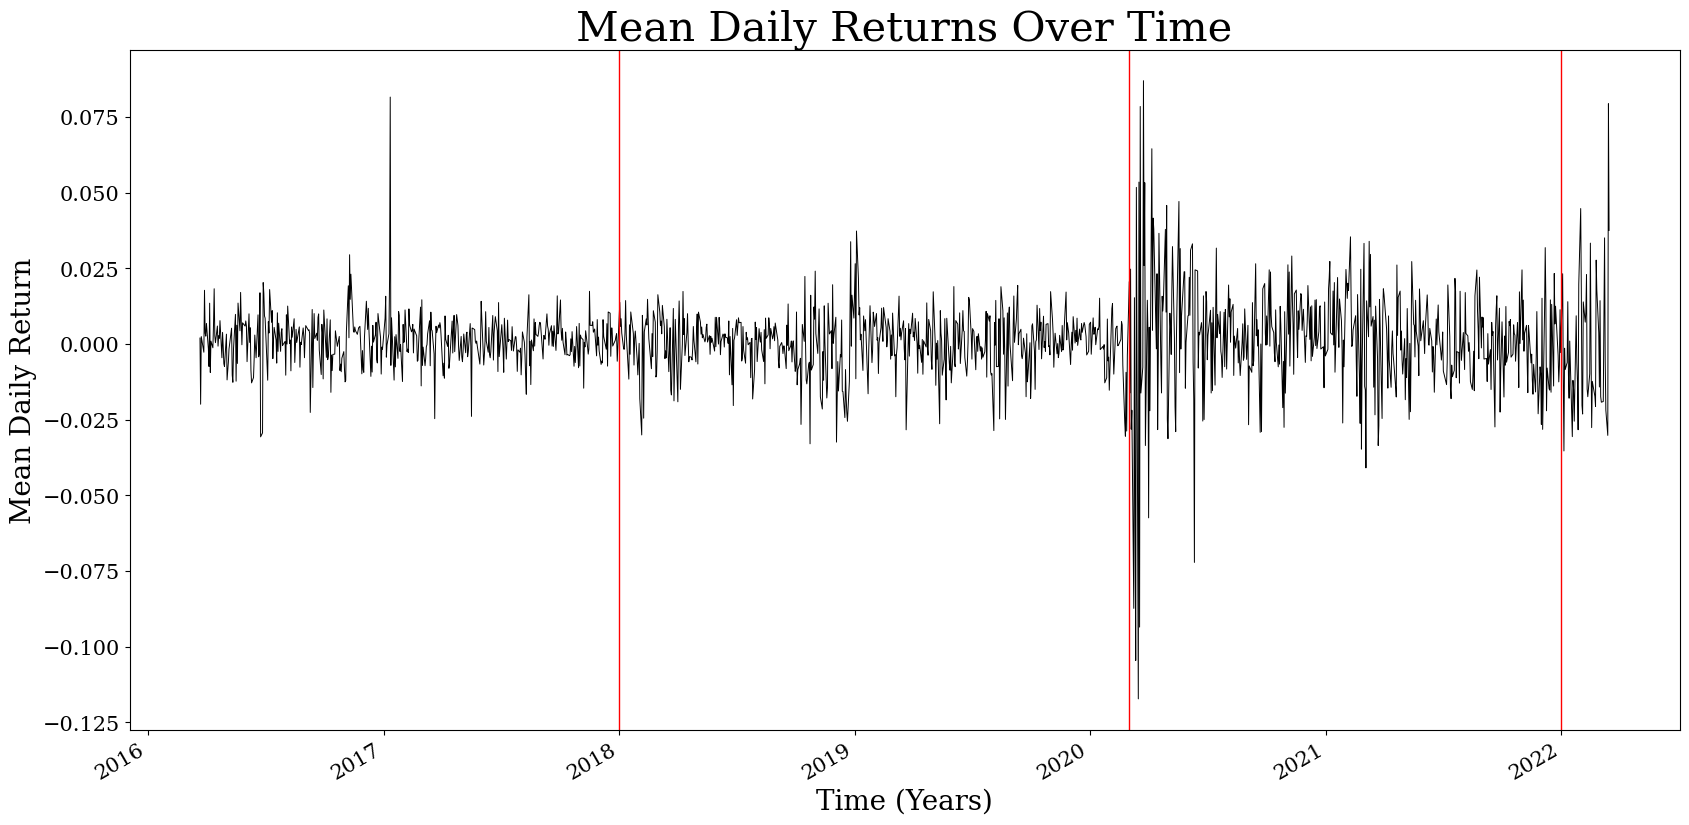

variance of the intervals
0.00008986519999999999
0.00037675559999999998


In [5]:
plt.rc('font', family='serif')
plt.rc('xtick')
plt.rc('ytick')

fig = plt.figure(figsize=(fig_height, 10))
ax = fig.add_subplot(1, 1, 1)

returns_companies = df_returns.mean(axis=1)
returns_companies.plot(color="k", linewidth=0.7)

ax.set_xlabel('Time (Years)', fontsize=label_size)
ax.set_ylabel('Mean Daily Return', fontsize=label_size)
ax.set_title('Mean Daily Returns Over Time', fontsize=title_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)

interval_borders = ["2018-01-01", "2020-03-01", "2021-12-31"] # TODO see if it makes sense to actually take first of Feb

for int_ in interval_borders:
    plt.axvline(x = int_, color = 'red', label = 'DD Event time', linewidth = 1)

plt.savefig(DATA_LOCATION +"visualisations/NYSE_daily_returns.svg", dpi=600, bbox_inches='tight')
plt.show()
# get var for the intervals
print("variance of the intervals")
print(f'{round(returns_companies.loc["2018-01-01":"2020-02-29"].var(),10):.20f}')
print(f'{round(returns_companies.loc["2020-03-01":"2021-12-31"].var(), 10):.20f}')


### Remove companies outside of the timeframe of interest

In [6]:
# this is the interval where filings are interesting to us
earliest_timestamp = list(investigation_periods.values())[0][0]
latest_timestamp = list(investigation_periods.values())[-1][1]
filings_removed = 0
filings_total = 0

for company in tqdm(companies):
    insider_data_df = company.insider_data_df
    filing_dates = insider_data_df.FilingDate.apply(lambda x: x.floor("d"))
    mask = (filing_dates >= earliest_timestamp) & (filing_dates <= latest_timestamp)
    company.insider_data_df = company.insider_data_df[mask]
    filings_removed += (~mask).sum()
    filings_total += mask.shape[0]

print("Total filings: {}".format(filings_total))
print("Removed {} filings".format(filings_removed))
print("Remaining filings: {}".format(filings_total - filings_removed))

100%|██████████| 2872/2872 [00:21<00:00, 130.61it/s]

Total filings: 1106364
Removed 767983 filings
Remaining filings: 338381


### Investigate Filing Trade Lag Times

In [7]:
print("get filing lags ...")

lags = []
for company in tqdm(companies):
    lag = UASC.analyse_single_company(company)
    lags.append(lag)


get filing lags ...


100%|██████████| 2872/2872 [00:35<00:00, 81.15it/s] 


Negative lag for 14 out of 338381 trades.
Lag longer than 21 days for 9598 out of 338381 trades.
Eligible trades: 328769 out of 338381 trades.


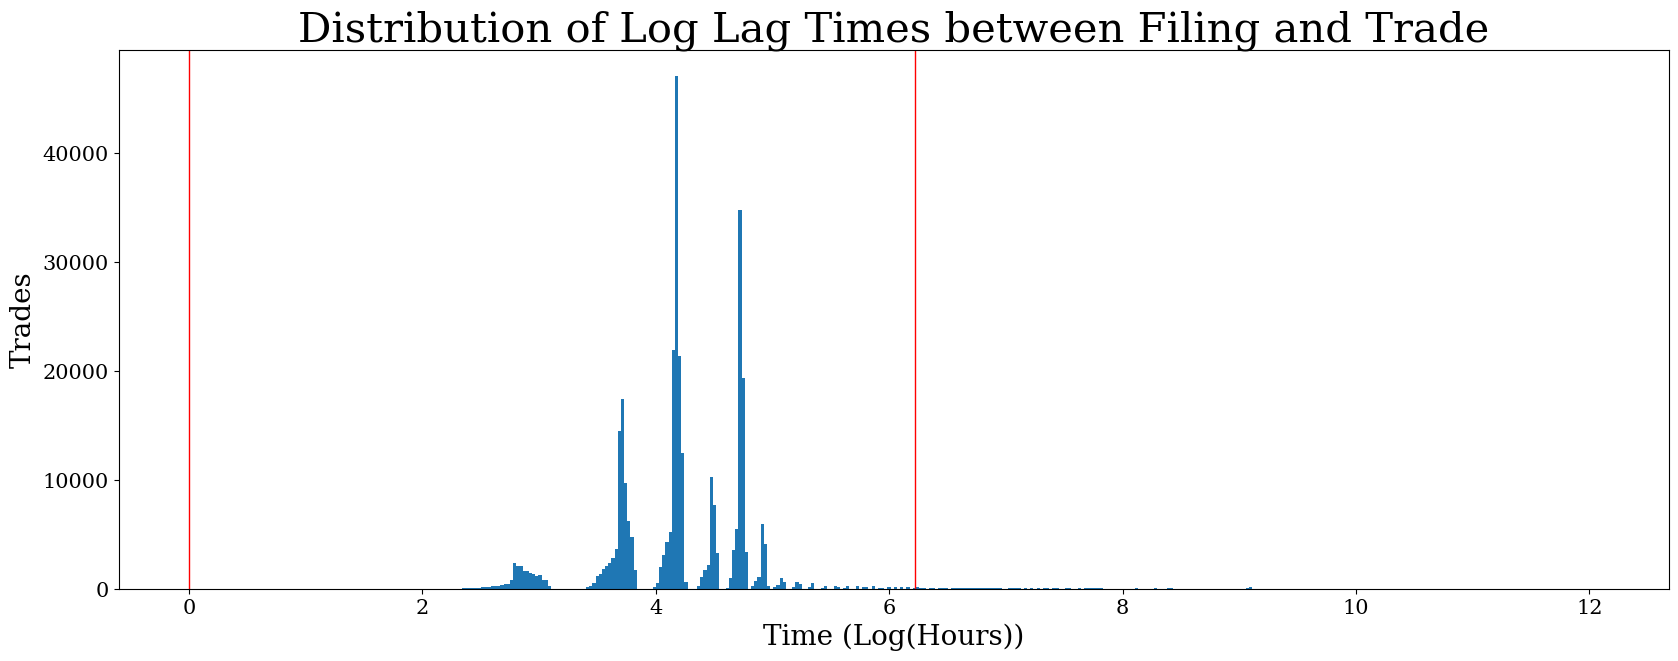

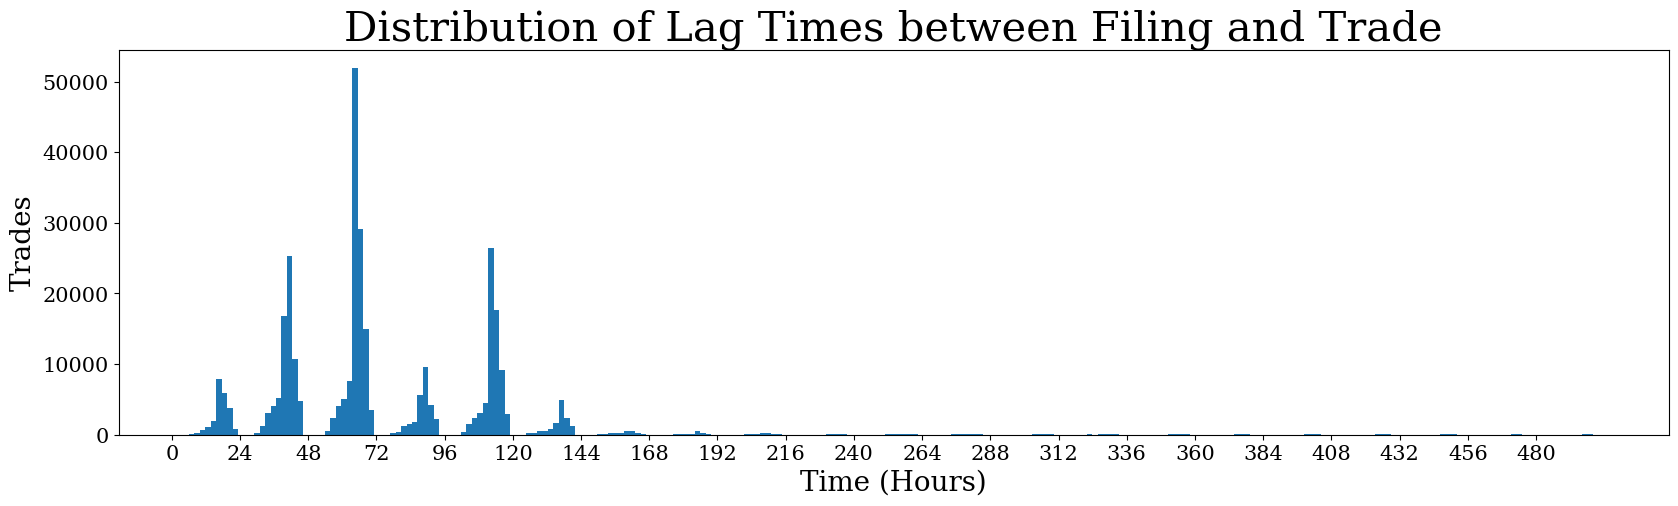

In [8]:
filing_trade_lags = sum(lags, [])

lag_in_hours = np.asarray(filing_trade_lags)
negative_lag_mask = lag_in_hours < 0
positive_lag = lag_in_hours[~negative_lag_mask]
in_21_days = positive_lag < 21*24
relevant_lag = positive_lag[in_21_days]
print(f"Negative lag for {negative_lag_mask.sum()} out of {len(negative_lag_mask)} trades.")
print(f"Lag longer than 21 days for {len(positive_lag) - len(relevant_lag)} out of {len(negative_lag_mask)} trades.")
print(f"Eligible trades: {len(relevant_lag)} out of {len(negative_lag_mask)} trades.")

fig = plt.figure(figsize=(fig_height, 7))
ax = fig.add_subplot(1, 1, 1)
plt.hist(np.log(positive_lag), bins="auto")
ax.set_xlabel('Time (Log(Hours))', fontsize=label_size)
ax.set_ylabel('Trades', fontsize=label_size)
ax.set_title('Distribution of Log Lag Times between Filing and Trade', fontsize=title_size)

plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)

plt.axvline(x = 0, color = 'red', label = 'Zero', linewidth = 1)
plt.axvline(x = np.log(21*24), color = 'red', label = 'Threshold', linewidth = 1)
plt.savefig(DATA_LOCATION +"visualisations/log_transformed_lags.svg", dpi=600, bbox_inches='tight')
plt.show()

without_outliers = positive_lag[positive_lag < 24*21]

fig = plt.figure(figsize=(fig_height, 5))
ax = fig.add_subplot(1, 1, 1)
plt.hist(without_outliers, bins="auto")
plt.xticks(np.arange(0, max(without_outliers) + 1, 24))
ax.set_xlabel('Time (Hours)', fontsize=label_size)
ax.set_ylabel('Trades', fontsize=label_size)
ax.set_title('Distribution of Lag Times between Filing and Trade', fontsize=title_size)

plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)

plt.savefig(DATA_LOCATION +"visualisations/lags_without_outliers.svg", dpi=600, bbox_inches='tight')
plt.show()

### Drop companies with lags longer than 21 days or negative lags

In [9]:
removed_lags = 0
remaining_lags = 0

for lags_c, company in tqdm(zip(lags, companies)):
    lags_c = np.asarray(lags_c)
    mask_eligible = (lags_c >= 0) & (lags_c <= 21*24)
    company.insider_data_df = company.insider_data_df[mask_eligible]
    removed_lags += (~mask_eligible).sum()
    remaining_lags += mask_eligible.sum()

print(f"Total trades: {removed_lags + remaining_lags}")
print(f"Removed {removed_lags} trades.")
print(f"Remaining {remaining_lags} trades.")


2872it [00:00, 4514.24it/s]

Total trades: 338381
Removed 9612 trades.
Remaining 328769 trades.


## Demonstrate process for a single event

### Define windows

#### Our data contains multiple companies. A single company contains multiple filings and each filing is an event

![alt text](assets/images/windows.png "Title")

In [10]:
## Constants defining how long both Estimation Window and Event Window are
### Probably also input parameters to a function call, as we need loops later...
L1_length = 100
L2_length = 40 # TODO +-20 days = 40 days, right?

### Fix a company

In [11]:
logging.getLogger().setLevel(logging.DEBUG)

if NAME == "Knudsen":
    company_index = -87
elif NAME == "Niedermayer":
    company_index = -11
else:
    raise NotImplementedError
company = companies[company_index]
print(company)
company_return = company.return_index_df

Company(company_type=519955, isin='US9406101082', name='WASHINGTON TST.BANC.', ticker='WASH', start_date=Timestamp('1987-06-08 00:00:00'), end_date=Timestamp('2022-03-16 00:00:00'), return_index_df=            ReturnIndex  company_return  market_return
Date                                                  
2016-03-21      1600.21             NaN            NaN
2016-03-22      1580.92       -0.012055       0.002677
2016-03-23      1560.78       -0.012739      -0.010944
2016-03-24      1559.94       -0.000538       0.000981
2016-03-28      1571.69        0.007532      -0.001380
...                 ...             ...            ...
2022-03-10      2844.15        0.008067      -0.009397
2022-03-11      2846.27        0.000745      -0.021792
2022-03-14      2853.15        0.002417      -0.020329
2022-03-15      2838.86       -0.005008       0.029218
2022-03-16      2866.39        0.009698       0.037688

[1509 rows x 3 columns], insider_data_df=       X          FilingDate  TradeDate Ticke

### Fix an event

In [12]:
# This date will be moved to a loop
## Define which periods we are looking at.

if NAME == "Knudsen":
    event_index = 60
elif NAME == "Niedermayer":
    event_index = -200
else:
    raise NotImplementedError
    
event_timestamp = company.insider_data_df.FilingDate.iloc[event_index].floor("d")
print("event timestamp: ", event_timestamp)

event timestamp:  2020-04-29 00:00:00


### Technical Checks

In [13]:
data_checks.run(L1_length, L2_length, event_timestamp, company_return)#, market_timeseries)

In [14]:
#company_return

### Determine T0, T1 and T2

In [15]:
T0_, T1_, T2_, T0, T1, T2, ERROR, msg = determine_T0_T1_T2.run(L1_length, L2_length, event_timestamp, company_return)#, market_timeseries)

DEBUG:root:Found T1 to be 2020-03-31 00:00:00 on index 1014
DEBUG:root:Found T2 to be 2020-05-28 00:00:00 on index 1054
DEBUG:root:Found T0 to be 2019-11-05 00:00:00 on index 914
DEBUG:root:------------------------------
DEBUG:root:Event occurred at             2020-04-29 00:00:00
DEBUG:root:Estimation Window (100 days): from 2019-11-05 00:00:00 to 2020-03-31 00:00:00
DEBUG:root:Event Window      ( 40 days): from 2020-03-31 00:00:00 to 2020-05-28 00:00:00


In [16]:
print(event_timestamp)
company_return

2020-04-29 00:00:00


,ReturnIndex,company_return,market_return
Date,,,
2016-03-21,1600.21,NaN,NaN
2016-03-22,1580.92,-0.012055,0.002677
2016-03-23,1560.78,-0.012739,-0.010944
2016-03-24,1559.94,-0.000538,0.000981
2016-03-28,1571.69,0.007532,-0.001380
...,...,...,...
2022-03-10,2844.15,0.008067,-0.009397
2022-03-11,2846.27,0.000745,-0.021792
2022-03-14,2853.15,0.002417,-0.020329


### Abnormal and Normal Returns

![alt text](assets/images/return_estimation.png "Title")

### Cut return timeseries into correct periods

In [17]:
windows = cut_timeseries.run(company_return, T0, T1, T2)
estimation_window_market_return, estimation_window_company_return, event_window_market_return, event_window_company_return = windows

DEBUG:root:shapes (Shouldnt be an issue after better preprocessing)
DEBUG:root:# estimation_window_market_return: (100,)
DEBUG:root:# estimation_window_market_return: (100,)
DEBUG:root:# event_window_market_return: (41,)
DEBUG:root:# event_window_company_return: (41,)


### Calculate coefficients

In [18]:
alpha, beta, eps = calculate_coefficients.run(estimation_window_market_return, estimation_window_company_return)

### The Abnormal Return
This is the last step of the whole process for one event

In [19]:
company_return = event_window_company_return
market_return = event_window_market_return
estimated_return = alpha + beta*market_return
abnormal_return = company_return - estimated_return
print(abnormal_return)

Date
2020-03-31    0.015038
2020-04-01   -0.008378
2020-04-02    0.007392
2020-04-03   -0.050383
2020-04-06   -0.037272
2020-04-07    0.006174
2020-04-08    0.019837
2020-04-09    0.077665
2020-04-13   -0.078237
2020-04-14   -0.043928
2020-04-15   -0.043081
2020-04-16   -0.063083
2020-04-17    0.023816
2020-04-20   -0.013112
2020-04-21    0.041709
2020-04-22   -0.044649
2020-04-23    0.011941
2020-04-24   -0.000461
2020-04-27    0.019756
2020-04-28    0.062862
2020-04-29   -0.000734
2020-04-30   -0.037637
2020-05-01    0.000230
2020-05-04   -0.015704
2020-05-05   -0.053066
2020-05-06   -0.023139
2020-05-07   -0.011166
2020-05-08    0.016481
2020-05-11   -0.046894
2020-05-12   -0.034744
2020-05-13   -0.014224
2020-05-14   -0.011083
2020-05-15   -0.019337
2020-05-18    0.035742
2020-05-19   -0.026794
2020-05-20    0.028043
2020-05-21    0.005195
2020-05-22    0.000625
2020-05-26    0.061318
2020-05-27    0.053101
2020-05-28   -0.014676
dtype: float64


<AxesSubplot:xlabel='Date'>

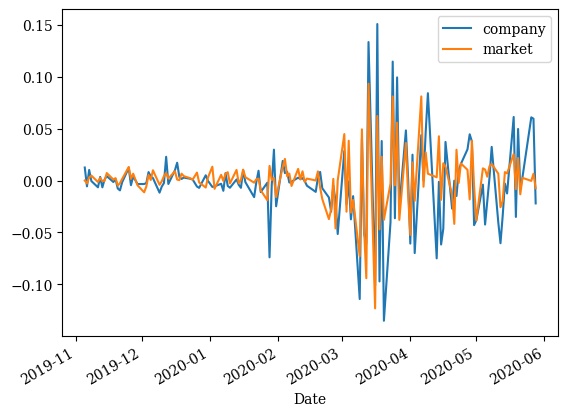

In [20]:
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

company_and_estimated = pd.DataFrame({"company":event_window_company_return, "market":estimated_return})
company_and_market = pd.DataFrame({"company": estimation_window_company_return, "market":estimation_window_market_return})
df_to_plot = pd.concat([company_and_market, company_and_estimated])
df_to_plot.plot()

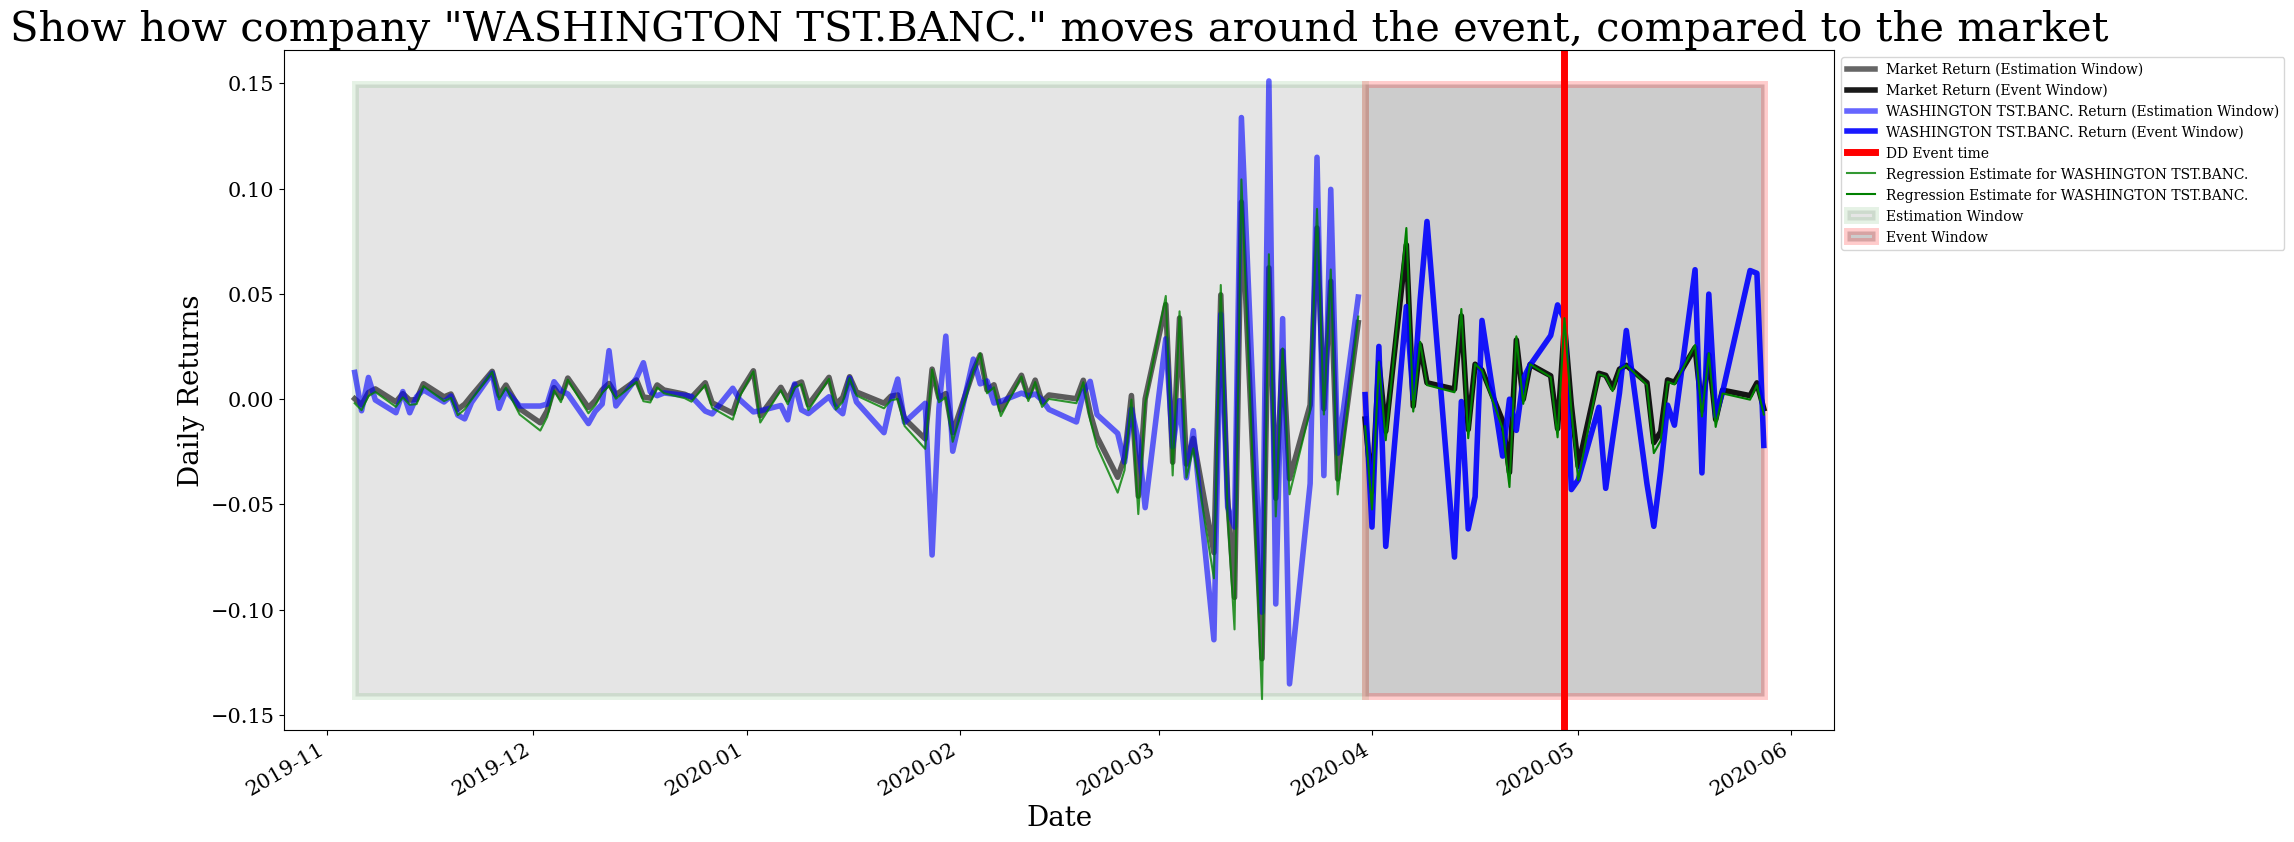

I'm impressed! It looks like a five-year-old drew this plot in paint


In [21]:
Company_name = company.name

# Estimations
est_estimation = estimation_window_market_return * beta + alpha
est_event = event_window_market_return * beta + alpha

plt.figure(figsize=(fig_height,10))
estimation_window_market_return.plot(color = 'black', alpha = 0.6, linewidth=4, label = 'Market Return (Estimation Window)')
event_window_market_return.plot(color = 'black', alpha = 0.9, linewidth=4, label = 'Market Return (Event Window)')

estimation_window_company_return.plot(color = 'blue', alpha = 0.6, linewidth = 4, label = f'{Company_name} Return (Estimation Window)')
event_window_company_return.plot(color = 'blue', alpha = 0.9, linewidth = 4, label = f'{Company_name} Return (Event Window)')

plt.axvline(x = event_timestamp, color = 'red', label = 'DD Event time', linewidth = 5)
plt.ylabel(f'Daily Returns', fontsize=label_size)
est_estimation.plot(color = 'green', label = f'Regression Estimate for {Company_name}', alpha = 0.8)
est_event.plot(color = 'green', label = f'Regression Estimate for {Company_name}', alpha = 1)

plt.axvspan(T0, T1, ymin = 0.05, ymax = 0.95, facecolor='black', alpha=0.1, label = 'Estimation Window', edgecolor='g', linewidth=5)
plt.axvspan(T1, T2, ymin = 0.05, ymax = 0.95, facecolor='black', alpha=0.2, label = 'Event Window', edgecolor='r', linewidth=5)
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')

plt.title(f'Show how company "{Company_name}" moves around the event, compared to the market', fontsize = title_size)
plt.xlabel('Date', fontsize=label_size)

plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.show()
print("I'm impressed! It looks like a five-year-old drew this plot in paint")


## Macro Analysis

### Now that we have seen the process for one single filing, let us do the same for all filings in all companies


In [22]:
# Initialize testing
logging.getLogger().setLevel(logging.ERROR)
# Helpers
multiind, data, data_errors = [], [], []
estimation_window_market_return_list, event_window_market_return_list, eps_list = [], [], []
n_companies = len(companies)


#for j in tqdm(range(len(companies[:200]))):
for j in tqdm(range(len(companies))):
    # Get information from said company
    company = companies[j]
    company_return = company.return_index_df
    
    n_filings = len(company.insider_data_df)
    # Go through all filings
    for i in company.insider_data_df.FilingDate.index:

        # Find our event date from filing
        filing_date = company.insider_data_df.FilingDate[i]
        event_timestamp = filing_date.floor("d")

        checks = data_checks.run(L1_length, L2_length, event_timestamp, company_return)
        if checks:
            #print(checks[1])
            data_errors.append(checks[0])
            continue
   
        ## Proceed to find periods
        T0_, T1_, T2_, T0, T1, T2, ERRORS, msg = determine_T0_T1_T2.run(L1_length, L2_length, event_timestamp, company_return)
        if ERRORS:
            #print(msg)
            data_errors.append(ERRORS)
            continue
            
        ## Cut timeseries to the relevant periods, and split them
        windows = cut_timeseries.run(company_return, T0, T1, T2)
        estimation_window_market_return, estimation_window_company_return,event_window_market_return, event_window_company_return = windows
        alpha, beta, eps = calculate_coefficients.run(estimation_window_market_return, estimation_window_company_return) # TODO change back to calculate_coefficients.run or check validity
        ## Calculate the abnormal returns
        abnormal_return = event_window_company_return - alpha - beta*event_window_market_return
        
        ## Append to results
        estimation_window_market_return_list.append(estimation_window_market_return)
        event_window_market_return_list.append(event_window_market_return)
        eps_list.append(eps)
        multiind.append((company.ticker, i, company.insider_data_df.TradeType[i], event_timestamp))
        data.append(abnormal_return)

100%|██████████| 2872/2872 [06:29<00:00,  7.38it/s]


In [23]:
# process and save abnormal returns
df_abnormal_returns = pd.DataFrame.from_records([d.reset_index(drop=True) for d in data])
df_abnormal_returns.index = pd.MultiIndex.from_tuples(multiind, names=["Company", "i", "TradeType", "event_timestamp"])

In [24]:
df_abnormal_returns

0         1         2   \
Company i  TradeType           event_timestamp                                 
IMTE    2  A - Grant           2020-10-20       0.015752 -0.048422  0.044437   
        3  M - OptEx           2020-10-20       0.015752 -0.048422  0.044437   
ACGL    14 F - Tax             2021-11-18       0.002259  0.012102 -0.002863   
        15 M - OptEx           2021-11-18       0.002259  0.012102 -0.002863   
        16 S - Sale+OE         2021-11-18       0.002259  0.012102 -0.002863   
...                                                  ...       ...       ...   
NESR    1  P - Purchase        2018-06-08      -0.000215  0.000430 -0.002691   
        2  A - Grant           2018-06-08      -0.000215  0.000430 -0.002691   
        3  C - Converted deriv 2018-06-08      -0.000215  0.000430 -0.002691   
        4  P - Purchase        2018-05-15       0.001948  0.003880 -0.005122   
SJ      0  C - Converted deriv 2020-05-11       0.000678 -0.000735 -0.000011   

                                                      3         4         5   \
Company i  TradeType           event_timestamp                                 
IMTE    2  A - Grant           2020-10-20      -0.025846 -0.037476 -0.035391   
        3  M - OptEx           2020-10-20      -0.025846 -0.037476 -0.035391   
ACGL    14 F - Tax             2021-11-18      -0.004885 -0.019132 -0.015840   
        15 M - OptEx           2021-11-18      -0.004885 -0.019132 -0.015840   
        16 S - Sale+OE         2021-11-18      -0.004885 -0.019132 -0.015840   
...                                                  ...       ...       ...   
NESR    1  P - Purchase        2018-06-08      -0.000063  0.000845  0.005833   
        2  A - Grant           2018-06-08      -0.000063  0.000845  0.005833   
        3  C - Converted deriv 2018-06-08      -0.000063  0.000845  0.005833   
        4  P - Purchase        2018-05-15       0.001846 -0.002094 -0.001104   
SJ      0  C - Converted deriv 2020-05-11      -0.001373 -0.000390  0.005710   

                                                      6         7         8   \
Company i  TradeType           event_timestamp                                 
IMTE    2  A - Grant           2020-10-20       0.030966 -0.027908  0.031977   
        3  M - OptEx           2020-10-20       0.030966 -0.027908  0.031977   
ACGL    14 F - Tax             2021-11-18      -0.007468  0.013816  0.011539   
        15 M - OptEx           2021-11-18      -0.007468  0.013816  0.011539   
        16 S - Sale+OE         2021-11-18      -0.007468  0.013816  0.011539   
...                                                  ...       ...       ...   
NESR    1  P - Purchase        2018-06-08      -0.000101  0.002727 -0.007979   
        2  A - Grant           2018-06-08      -0.000101  0.002727 -0.007979   
        3  C - Converted deriv 2018-06-08      -0.000101  0.002727 -0.007979   
        4  P - Purchase        2018-05-15       0.000846 -0.000046  0.004920   
SJ      0  C - Converted deriv 2020-05-11      -0.005951  0.000744 -0.000771   

                                                      9   ...        31  \
Company i  TradeType           event_timestamp            ...             
IMTE    2  A - Grant           2020-10-20      -0.010446  ... -0.017652   
        3  M - OptEx           2020-10-20      -0.010446  ... -0.017652   
ACGL    14 F - Tax             2021-11-18      -0.004609  ...  0.015057   
        15 M - OptEx           2021-11-18      -0.004609  ...  0.015057   
        16 S - Sale+OE         2021-11-18      -0.004609  ...  0.015057   
...                                                  ...  ...       ...   
NESR    1  P - Purchase        2018-06-08      -0.003118  ... -0.000936   
        2  A - Grant           2018-06-08      -0.003118  ... -0.000936   
        3  C - Converted deriv 2018-06-08      -0.003118  ... -0.000936   
        4  P - Purchase        2018-05-15      -0.003142  ... -0.000109   
SJ      0  C - Converted deriv 

In [25]:
df_estimation_window_market_return = pd.DataFrame.from_records([d.reset_index(drop=True) for d in estimation_window_market_return_list])
df_estimation_window_market_return.index = pd.MultiIndex.from_tuples(multiind, names=["Company", "i", "TradeType", "event_timestamp"])

In [26]:
df_event_window_market_return = pd.DataFrame.from_records([d.reset_index(drop=True) for d in event_window_market_return_list])
df_event_window_market_return.index = pd.MultiIndex.from_tuples(multiind, names=["Company", "i", "TradeType", "event_timestamp"])

In [27]:
df_eps = pd.DataFrame.from_records([d.reset_index(drop=True) for d in eps_list])
df_eps.index = pd.MultiIndex.from_tuples(multiind, names=["Company", "i", "TradeType", "event_timestamp"])

### Show the reasons filings were dropped

In [28]:
errors_df = pd.DataFrame.from_records(data_errors)
errors_agg = errors_df.sum(axis=0)

In [29]:
# add earlier filtering
errors_agg["event not in overall time frame"] = filings_removed
errors_agg["negative lags"] = negative_lag_mask.sum()
errors_agg["more than 21 days lag"] = len(positive_lag) - len(relevant_lag)

In [30]:
errors_agg = pd.DataFrame(errors_agg)
errors_agg.index.name = "Reason"
errors_agg.columns = ["Count"]

In [31]:
print(errors_agg.astype(int).reset_index().to_latex(index=False))

\begin{tabular}{lr}
\toprule
                                        Reason &  Count \\
\midrule
  Not enough days before event in company data &   8460 \\
    Don't have enough trading days after event &   1332 \\
event\_timestamp not in the company return data &    977 \\
               event not in overall time frame & 767983 \\
                                 negative lags &     14 \\
                         more than 21 days lag &   9598 \\
\bottomrule
\end{tabular}



C:\Users\waxfa\AppData\Local\Temp\ipykernel_27200\3086088863.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(errors_agg.astype(int).reset_index().to_latex(index=False))


In [32]:
print(errors_agg.sum())

Count    788364.0
dtype: float64


In [33]:
df_abnormal_returns.to_pickle(f"data/{NAME}/calculate_AR_results/df_abnormal_returns.pkl")
df_estimation_window_market_return.to_pickle(f"data/{NAME}/calculate_AR_results/df_estimation_window_market_return.pkl")
df_event_window_market_return.to_pickle(f"data/{NAME}/calculate_AR_results/df_event_window_market_return.pkl")
df_eps.to_pickle(f"data/{NAME}/calculate_AR_results/df_eps.pkl")

with open(f"data/{NAME}/calculate_AR_results/companies.pkl", "wb") as f:
    pickle.dump(companies, f)